# Chebyshev approximation

Given a smooth (analytic) function $f(x)$ on $x \in [-1,1]$ (or any other interval via a trivial change of variables), we can approximate it to *exponentially good* accuracy by a truncated **cosine series** using the change of variables $x=\cos \theta$:
$$
f(x) = f(\cos\theta) = \sum_{k=0}^\infty ' a_k \cos(k\theta) 
=  \sum_{k=0}^\infty ' a_k \underbrace{\cos(k \cos^{-1} x)}_{T_k(x)}
$$
(where $\sum'$ denotes that the $k=0$ term has weight 1/2).  An **wonderful fact** is that $T_k(x) =\cos(k \cos^{-1} x)$ is a **polynomial in x** of degree *k*, a [Chebyshev polynomial](https://en.wikipedia.org/wiki/Chebyshev_polynomials). 

Furthermore, the $a_k$ of the infinite series can be computed to exponentially good accuracy using $f(x)$ evaluated a discrete set of $N+1$ **Chebyshev points** $x_n = \cos(n\pi/N)$ for $n=0,\ldots,N$, which can be thought of as a trapezoidal-rule approximation for the [Fourier cosine series](https://en.wikipedia.org/wiki/Fourier_sine_and_cosine_series) integral $a_k = \frac{2}{\pi}\int_0^\pi f(x) \cos(kx) dx$, or can be thought of as an exact [trigonometric interpolation](https://en.wikipedia.org/wiki/Trigonometric_interpolation) based on a [discrete cosine transform (DCT-I)](https://en.wikipedia.org/wiki/Discrete_cosine_transform).

The end result is that you can evaluate $f(x)$ at a relatively **small** number $N+1$ of points, replace it with a **polynomial** of degree $N$ that is *exponentially close* to $f(x)$ (error decreases exponentially with $N$).

# ApproxFun

[ApproxFun.jl](https://github.com/JuliaApproximation/ApproxFun.jl) is a Julia package that can take any function on any interval and replace it with a **Chebyshev-polynomial approximation accurate to nearly machine precision** (plus various generalizations thereof).

The advantage of this is that **polynomials are easy**: anything you might want to do with a function is probably easier with a polynomial.  Integration, differentiation, root-finding (by a [companion matrix](https://en.wikipedia.org/wiki/Companion_matrix) of the polynomial), and so on.  Even solving partial differential equations!

Another way of putting it is that the polynomial approximation replaces *infinite-dimensional problems* (functions at every $x\in[a,b]$) with *finite-dimensional problems* (vectors of a finite number of polynomial coefficients).

ApproxFun makes this easy.   It follows in the tradition of the pioneering [chebfun software](https://www.chebfun.org/) for Matlab.   These are also closely related to what are called **spectral methods** for PDEs, and another nice embodiment can be found in the [Dedalus project](https://dedalus-project.org/).

In [1]:
using ApproxFun, Plots

The central object in ApproxFun is a `Fun`, which can be thought of as simply a **wrapper around a polynomial**.

You construct a `Fun` by giving a **function and an interval a..b**.  It then samples your function at an increasing number of Chebyshev points until it obtains a polynomial approximant **near machine-precision accuracy**.

Let's construct a `Fun` in the interval $[0,3]$ using the `identity` function `x -> x`, which of course is trivial (it is *exactly* a polynomial):

In [2]:
x = Fun(identity, 0..3)

Fun(Chebyshev(0..3),[1.5, 1.5])

In fact, we can see the coefficients $a_k$ of the Chebyshev polynomials inside the `Fun` by looking at `x.coefficients`:

In [3]:
x.coefficients

2-element Vector{Float64}:
 1.5
 1.5

(Here, the 1.5 comes from the change of variables $[0,3] \to [-1,1]$.)

Given a `Fun`, the important thing is that we can now make *other* `Fun` objects by arithemtic operations, adaptively increasing the polynomial degree until near machine accuracy is reached.

For example, `sin(x^2 + 4cos(3x))` constructs a new `Fun` representing the function $\sin(x^2 + 4\cos(3x))$, which will require a much higher-degree polynomial to represent accurately on $[0,3]$:

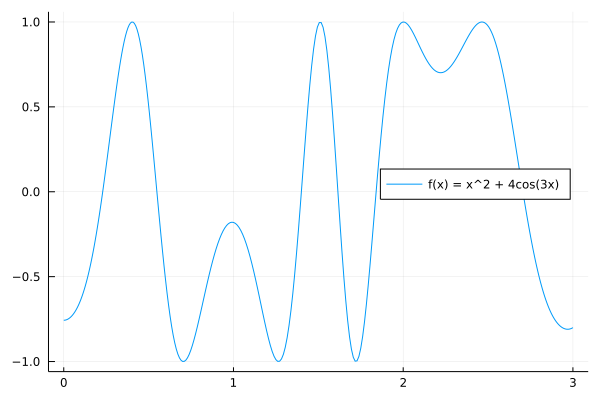

In [4]:
f = sin(x^2 + 4cos(3x))
plot(f, label="f(x) = x^2 + 4cos(3x)", legend=:right)

We can see that this *new* `Fun` object `f` has 124 coefficients, corresponding to a **degree 123 polynomial** that was obtained by **sampling f at 124 points**.

An important thing to remember is that there is *no problem in working with very high-degree polynomials* as long as we use the Chebyshev-polynomial basis and sample at Chebyshev points, because they are basically cosine series in disguise.  (We could easily go to degrees of millions without encountering any numerical difficulties.)

In [5]:
f.coefficients

124-element Vector{Float64}:
 -0.13499279321680102
  0.10923232571205106
 -0.37333520174777396
 -0.3791924956613899
 -0.48921380604432585
  0.28831141706582364
  0.018069690612804563
  0.09528802290764
  0.22833013987668332
 -0.19283301232310207
  0.08646660502423381
  0.011016201145921759
 -0.08711576680372804
  ⋮
 -4.7860231383692114e-17
 -9.73182777431717e-17
  1.2367652518734565e-17
  3.5804124476462526e-17
 -2.6301823255601307e-18
 -1.2981006664664577e-17
  2.9180208079477535e-19
  4.619098468208962e-18
  1.2039982164168814e-19
 -1.5956648959835444e-18
 -1.2863591098981478e-19
 -5.609677098557553e-19

Notice that the coefficients get quite small near the end.  Because this function is analytic, the coefficients $a_k$ actually decay (at least) **exponentially** fast with $k$, which is why we can get ≈15 digits of accuracy with only ≈100 points.

We can see this exponential convergence if we plot the coefficients on a semi-log scale:

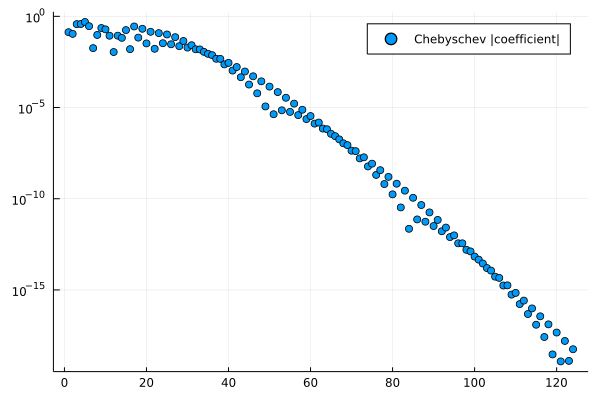

In [6]:
scatter(abs.(f.coefficients), yscale=:log10, label="Chebyschev |coefficient|")

Again, at this point we have *thrown away the original function* and only have the *polynomial* `f`.

Given this polynomial, we can construct other, even more-complicated functions.  Here is a nasty function that includes "sharp" (narrow, but smooth) peak:

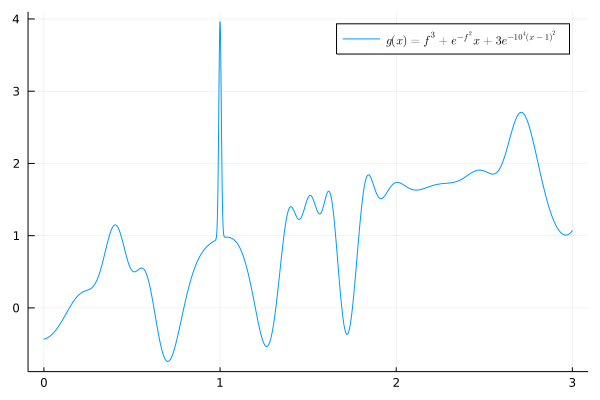

In [7]:
g = f^3 + exp(-f^2)*x + 3exp(-10000(x-1)^2)
plot(g; label="\$g(x) = f^3 + e^{-f^2}x + 3e^{-10^4(x-1)^2}\$", legend=:topright)

This requires a polynomial of a **much higher degree ≈2000** to interpolate accurately:

In [8]:
length(g.coefficients)

1797

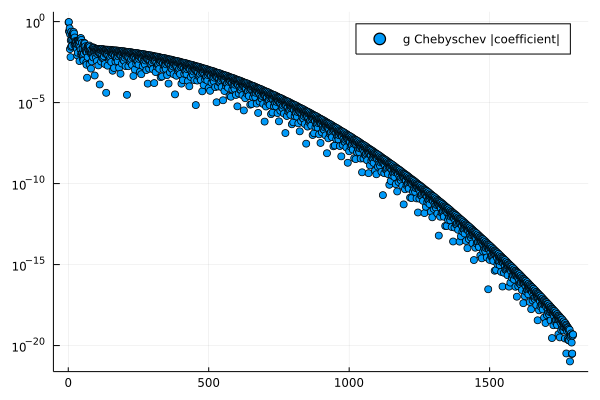

In [9]:
scatter(abs.(g.coefficients), yscale=:log10, label="g Chebyschev |coefficient|")

### Integrals

Integrating arbitrary functions is hard, but **integrating polynomials is easy**.

Given a `Fun` (which internally is just a polynomial), we can ask ApproxFun to integrate it for us using the `sum` function.

This gives us the integral to nearly machine precision, and is essentially equivalent to [Clenshaw–Curtis quadrature](https://en.wikipedia.org/wiki/Clenshaw%E2%80%93Curtis_quadrature):

In [10]:
sum(f)

0.05371061531366143

How can we check that this is the right answer?

We can use a completely different numerical integration algorithm provided by the [QuadGK.jl package](https://github.com/JuliaMath/QuadGK.jl), which uses h-adaptive [Gauss–Kronrod quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Kronrod_quadrature_formula):

In [11]:
using QuadGK
I, E = quadgk(x -> sin(x^2 + 4cos(3x)), 0, 3)

(0.0537106153136597, 4.817794843625656e-10)

The second return value is an error estimate, but for smooth functions this error estimate is typically quite conservative, and in fact it matches the output of ApproxFun's `sum` to nearly machine precision:

In [12]:
@show sum(f) - I
(sum(f) - I) / I # relative error

sum(f) - I = 1.734723475976807e-15


3.229759081787379e-14

### Differentiation

Differentiating polynomials is even easier than integrating them.  In ApproxFun, you just use the natural notation `f'`:

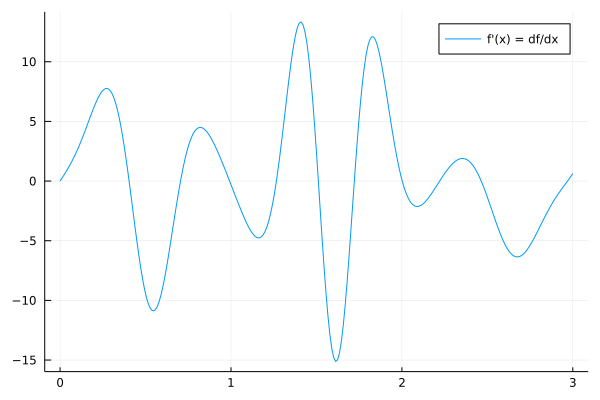

In [13]:
plot(f', label="f'(x) = df/dx")

### Roots

Suppose that we want the roots $f(x) = 0$.   Moreover, we want *all* the roots of `f(x)` on the interval $[0,3]$.

For an arbitrary function, this is quite a tricky problem.  [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) can give you accurate roots given starting guesses near the roots, but how would you find starting guesses near *all* of the roots?  You'd have to do some kind of systematic search.

In contrast, with a polynomial you can find its roots simply by computing the eigenvalues of its [companion matrix](https://en.wikipedia.org/wiki/Companion_matrix), and fortunately there are good eigenvalue algorithms such as the [QR algorithm](https://en.wikipedia.org/wiki/QR_algorithm).   Then we just keep the real eigenvalues in $[0,3]$.

In ApproxFun, this is computed by `roots(f)`.  (Here, `f` is "only" degree 123, so the companion-matrix eigenvalue problem is *tiny* by modern standards!)

In [14]:
roots(f)

6-element Vector{Float64}:
 0.2294828908828701
 0.5487130280947282
 1.4000786810232655
 1.6152960092571853
 1.8405877225588667
 2.7052558139842833

It's nice to plot them:

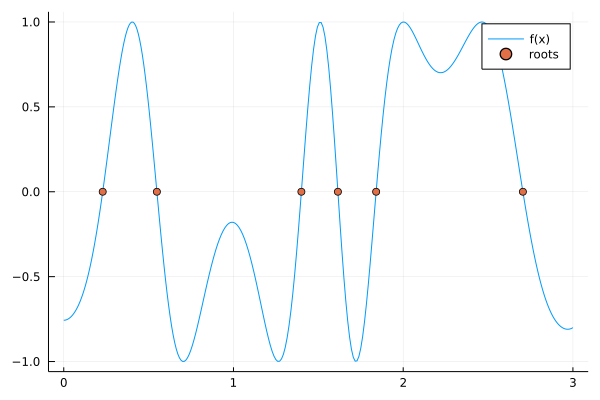

In [15]:
plot(f; label="f(x)")
r = roots(f)
scatter!(r, f.(r); label="roots")

If we also compute `roots(f')`, i.e. the roots of the derivative $f'(x)=0$, then this additionally gives us **all the extrema** of $f(x)$ on $[0,3]$:

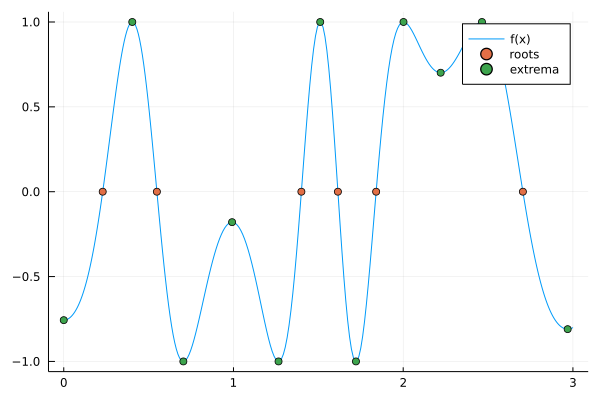

In [16]:
plot(f; label="f(x)")
r = roots(f)
scatter!(r, f.(r); label="roots")
rp = roots(f')
scatter!(rp, f.(rp); label="extrema")

## Non-smooth functions

Of course, the Achilles heel of Chebyshev approximation, and all spectral methods, is that they only converge exponentially rapidly for *smooth* functions (technically, functions that are analytic in a neighborhood of the domain).

If a function has a discontinuity in some derivative, or some other singularity, then Chebyshev polynomials converge quite slowly!

A trick, however, is that **if we know the singularity/discontinuity**, then we can build that singularity into our basis functions.   For example, if we know we have a discontinuity at $x=1$, we can simply use *two* polynomial expansions, one for $x\in [0,1]$ and another for $x\in [1,3]$.

In cases where you build a `Fun` from other `Fun`s using building blocks with known singularities, like the `abs(x)` function (which has a kink at $x=0$), then `ApproxFun` can often build this "smart" expansion for you:

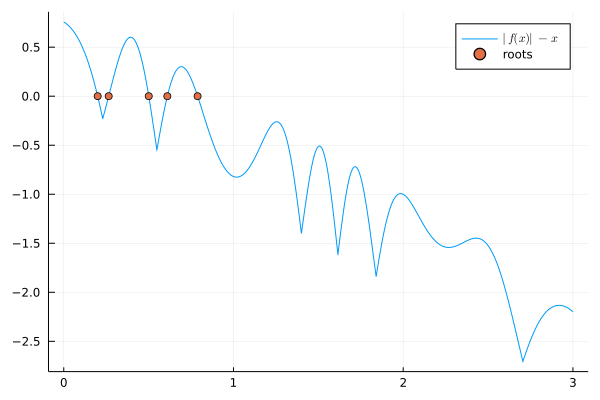

In [17]:
h = abs(f)-x
plot(h; label="\$|f(x)|-x\$")
r = roots(h)
scatter!(r, h.(r); label="roots")

Here, the function $|f(x)|-x$ has a discontinuous derivative whereever $f(x)=0$.

But we already saw that ApproxFun can compute the roots of $f$ to high accuracy!  So, internally, it has enough information to "break up" its `Fun` into different polynomial approximations at every root.

We can see this if we look inside $h$: its domain is described by a `PiecewiseSegment` that breaks the domain $[0,3]$ into a set of subintervals:

In [18]:
dump(h.space.domain)

PiecewiseSegment{Float64}
  points: Array{Float64}((8,)) [0.0, 0.2294828908828701, 0.5487130280947282, 1.4000786810232655, 1.6152960092571853, 1.8405877225588667, 2.7052558139842833, 3.0]


and as expected, the `points` where the subdivisions occur exactly coincide with the roots of $f(x)$ as computed by `roots(f)`:

In [19]:
h.space.domain.points[2:end-1] == roots(f)

true